<a href="https://colab.research.google.com/github/As-12/Temple-Image-Classification/blob/master/3_Temple_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Temple Classification

### Author
   Thanaphon Chavengsaksongkram

   contact@thanaphon.dev

   https://thanaphon.dev

### MIT 3.0 License

Copyright 2020 Thanaphon Chavengsaksongkram

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.

# Introduction

Wat Phra Kaew and Wat Pho are one of the most popular temples in Thailand. Thousands of visitors across the world travel to Thailand every year to appreciate the architecture wonders the temples have to offer. 

Unfortunately, many visitors of the temples often get confused about whether their vacation pictures are taken at Wat Phra Kaew or Wat Pho. In order to salvage what's remained of their trip, a machine learning specialist is contacted and tasked with creating a Machine Learning model that can distinguish the photos taken from Wat Phra Kaew and Wat Pho.



![wat phra kaew picture from wikipedia](https://upload.wikimedia.org/wikipedia/commons/thumb/c/c1/Wat_Phra_Kaew_by_Ninara_TSP_edit_crop.jpg/520px-Wat_Phra_Kaew_by_Ninara_TSP_edit_crop.jpg)


A sample image of Wat Phra Kaew


![wat pho picture from wikipedia](https://upload.wikimedia.org/wikipedia/commons/thumb/e/ec/BOB_3205-3.jpg/340px-BOB_3205-3.jpg)

A sample image of Wat Pho

# Objective

The goal is to develop a model that predicts whether a photo is taken at Wat Phra Kaew or Wat Pho - a binary classification problem. There is a possibility of pictures containing neither temples, but an assumption will be made that no such pictures exist in the samples. 

# Approach

This machine learning project consists of two primary tasks. Data mining and model development. As this model will not be deployed to production yet, model deployment and operationalization will not be covered.

First, the training dataset will be mined from the internet using Google and Bing image search API.  Roughly around 1,000 samples for each class should be sufficient. 

Second, because there is an abundant sample of the training dataset, a deep convolutional neural network will be deployed to handle this task. Convolutional Neural Network is generally better suited to handle high dimensionality of image data but it requires specialized hardware such as a Graphical Processing Unit (GPU) to process the information. Without specialized hardware and big training dataset, traditional computer vision approaches such as SIFT feature extraction and bag of SIFTs classification may be more suitable. 

Complicated Deep Neural Network usually requires extensive training with millions of training samples. With limited resources and time available, the transfer learning approach will be used in combination with state of the art CNN model, specifically, Google's inception v3 model. The Inception model is user-friendly and very robust against many types of variations such as scale, translation, and rotations.  Image preprocessing steps such as color standardization and data augmentation are generally not necessary.

# Training Dataset  

The training dataset will be collected by mining images from Google Image Search and Bing Image Search API. See Data Mining notebook for the documentation regarding this process. You can access it [here](https://colab.research.google.com/drive/1YVZQXqzqbGA1kbSkhwtQ9S_vMl7j6qe-?usp=sharing). 


# Performance Measure

The data provided by the reviewing committee will be used to validate the performance of the model. The model will be optimized and evaluated for precision as there is no repercussion for False Positive and False Negative. Nevertheless, ROC Curve and F1 score will also be calculated for reference purposes. 


# 1. Configurations

## 1.1 Imports

All the imports go here.


In [0]:
# set the matplotlib backend so figures can be saved in the background
import os
os.environ['KERAS_BACKEND'] = 'tensorflow'
import matplotlib
import keras
# import the necessary packages
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adam
from keras.optimizers import SGD
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import img_to_array
from keras.utils import to_categorical
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import argparse
import random
import cv2

import shutil
import fnmatch
import pickle
from keras import Model
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers import BatchNormalization
from keras.layers import Activation
from keras.layers import Input
from keras.constraints import max_norm
from keras import regularizers
from keras.layers.advanced_activations import LeakyReLU
import keras.initializers
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
import keras.optimizers
from keras.utils import np_utils
from keras import backend as K
from keras.applications.inception_v3 import InceptionV3

from sklearn.metrics import confusion_matrix
import seaborn as sns
import pandas as pd
import os
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import f1_score, roc_curve, auc
from sklearn.metrics import confusion_matrix, log_loss, precision_recall_fscore_support
from statistics import stdev, mean

%matplotlib inline

# Ignore warnings for final delivery
import warnings
warnings.filterwarnings('ignore')

Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## 1.2 Global Settings

These variables will be used across the project. 

In [0]:
#Random seeds
SEED = 2082018
np.random.seed(SEED)

#Image Settings
IMAGE_RESIZE = (299,299)  # Image size. Process on the by data generator. 
IMAGE_INPUT_SIZE = (299,299,3) #Image Input size to the neural network

#Training Settings
BATCH_SIZE = 32
EPOCH = 10

#Directories
# NOTE: The labels are determined by subfolders. PNG or JPEG images only.
TRAIN_DIR = '/content/drive/My Drive/Colab Notebooks/dataset/training/'
VAL_DIR = '/content/drive/My Drive/Colab Notebooks/dataset/validation/'
TEST_DIR =  '/content/drive/My Drive/Colab Notebooks/dataset/test/'

#Index of the class label represents numerical representation
CLASS_LABELS = ['0', '1']
CLASS_MEANING = ['Wat Pho', 'Wat Phra Kaew']
NUM_CLASSES = 2

#Checkpoints and save files

#Saving every epochs that improve val accuracy
MODEL_WEIGHT_FILE="temple-classification-inception-v3.hdf5"  

## 1.3 Mount Google Drive

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 1.4 Execution Environment Information

Obtaining available system memory and graphic card. This can influence training decisions. A low amount of available RAM will require the use of data streaming such as data generators and it will also affect image batch size.


In [0]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9

print("There are {:.1f} GB of RAM available".format(ram_gb))

There are 13.7 GB of RAM available


In [0]:
!nvidia-smi

Sun May 17 12:23:14 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.82       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   68C    P8    32W / 149W |      0MiB / 11441MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

# 2.0 Data Processing


## 2.1 Training / Valiation Split

Because it may not be feasible to load every image into one dataset and split them into several copies for training and testing. This task will copy the image from the original source and split them into an appropriate directory.

### 2.1.1 Wat Pho (Label 0)

There are 1000 images of Wat Pho. Split 200 for training validation.

In [0]:
run_this = False # Preventing accidental execution

if run_this == True:
  split_size = 200

  dataset_directory = '/content/drive/My Drive/Colab Notebooks/dataset/bing/wat pho/'
  train_directory = '/content/drive/My Drive/Colab Notebooks/dataset/training/0/'
  valid_directory = '/content/drive/My Drive/Colab Notebooks/dataset/validation/0/'

  # Split Validation Set
  count = 0
  for file in os.listdir(os.fsencode(dataset_directory)):
    filename = os.fsdecode(file)
    if count < split_size:
      src = os.path.join(dataset_directory, filename)
      dst = os.path.join(valid_directory, filename)
      print("Copying Validation: {} to {}".format(src, dst))
    else:
      src = os.path.join(dataset_directory, filename)
      dst = os.path.join(train_directory, filename)
      print("Copying Training: {} to {}".format(src, dst))
    shutil.copyfile(src, dst)
    count += 1

Copying Validation: /content/drive/My Drive/Colab Notebooks/dataset/bing/wat pho/Image_1.jpg to /content/drive/My Drive/Colab Notebooks/dataset/validation/0/Image_1.jpg
Copying Validation: /content/drive/My Drive/Colab Notebooks/dataset/bing/wat pho/Image_2.jpg to /content/drive/My Drive/Colab Notebooks/dataset/validation/0/Image_2.jpg
Copying Validation: /content/drive/My Drive/Colab Notebooks/dataset/bing/wat pho/Image_3.jpg to /content/drive/My Drive/Colab Notebooks/dataset/validation/0/Image_3.jpg
Copying Validation: /content/drive/My Drive/Colab Notebooks/dataset/bing/wat pho/Image_4.jpg to /content/drive/My Drive/Colab Notebooks/dataset/validation/0/Image_4.jpg
Copying Validation: /content/drive/My Drive/Colab Notebooks/dataset/bing/wat pho/Image_5.jpg to /content/drive/My Drive/Colab Notebooks/dataset/validation/0/Image_5.jpg
Copying Validation: /content/drive/My Drive/Colab Notebooks/dataset/bing/wat pho/Image_6.jpg to /content/drive/My Drive/Colab Notebooks/dataset/validation/

### 2.1.2 Wat Phra Kaew (Label 1)

There are 1000 images of Wat Phra Kaew. Split 200 for training validation. 

In [0]:
run_this = False # Preventing accidental execution

if run_this == True:
  split_size = 200

  dataset_directory = '/content/drive/My Drive/Colab Notebooks/dataset/bing/wat phra kaew/'
  train_directory = '/content/drive/My Drive/Colab Notebooks/dataset/training/1/'
  valid_directory = '/content/drive/My Drive/Colab Notebooks/dataset/validation/1/'

  # Split Validation Set
  count = 0
  for file in os.listdir(os.fsencode(dataset_directory)):
    filename = os.fsdecode(file)
    if count < split_size:
      src = os.path.join(dataset_directory, filename)
      dst = os.path.join(valid_directory, filename)
      print("Copying Validation: {} to {}".format(src, dst))
    else:
      src = os.path.join(dataset_directory, filename)
      dst = os.path.join(train_directory, filename)
      print("Copying Training: {} to {}".format(src, dst))
    shutil.copyfile(src, dst)
    count += 1

Copying Validation: /content/drive/My Drive/Colab Notebooks/dataset/bing/wat phra kaew/Image_1.jpg to /content/drive/My Drive/Colab Notebooks/dataset/validation/1/Image_1.jpg
Copying Validation: /content/drive/My Drive/Colab Notebooks/dataset/bing/wat phra kaew/Image_2.jpg to /content/drive/My Drive/Colab Notebooks/dataset/validation/1/Image_2.jpg
Copying Validation: /content/drive/My Drive/Colab Notebooks/dataset/bing/wat phra kaew/Image_3.jpg to /content/drive/My Drive/Colab Notebooks/dataset/validation/1/Image_3.jpg
Copying Validation: /content/drive/My Drive/Colab Notebooks/dataset/bing/wat phra kaew/Image_4.jpg to /content/drive/My Drive/Colab Notebooks/dataset/validation/1/Image_4.jpg
Copying Validation: /content/drive/My Drive/Colab Notebooks/dataset/bing/wat phra kaew/Image_5.jpg to /content/drive/My Drive/Colab Notebooks/dataset/validation/1/Image_5.jpg
Copying Validation: /content/drive/My Drive/Colab Notebooks/dataset/bing/wat phra kaew/Image_6.jpg to /content/drive/My Drive

## 2.2 Data Preprocessing

Minimal data preprocessing is required because Google's Inception v3 model is user-friendly and is generally robust against all kinds of variations. 

### 2.2.1 Resizing
Resize the image to fit the input layer.

In [0]:
def buildImageDataset(path, imageResize=None, shuffle=False, seed=0):
    """
    Load dataset into an array. Labels are defined by folder name.
    """
    filenames = []
    data = []
    labels = []
    imagePaths = sorted(list(paths.list_images(path)))
    
    if shuffle == True:
        random.seed(seed)
        random.shuffle(imagePaths)

    for imagePath in imagePaths:
        image = cv2.imread(imagePath)
        if imageResize != None:
            image = cv2.resize(image, imageResize)
        image = img_to_array(image)
        data.append(image)
        filenames.append(imagePath)
        label = imagePath.split(os.path.sep)[-2]
        labels.append(CLASS_LABELS.index(label))
    return (np.array(data), np.array(labels), np.array(filenames))

In [0]:
X_train, y_train, train_files = buildImageDataset(TRAIN_DIR,imageResize=IMAGE_RESIZE,seed=SEED)
X_valid, y_valid, valid_files = buildImageDataset(VAL_DIR,imageResize=IMAGE_RESIZE,seed=SEED)  

Sanity Check - Review the dimensions of the data

In [0]:
print ("Shape of the Training Input: {}".format(X_train.shape))
print ("Shape of the Training Target: {}".format(y_train.shape))

print ("Shape of the Validation Input: {}".format(X_valid.shape))
print ("Shape of the Validation Target: {}".format(y_valid.shape))

Shape of the Training Input: (1590, 299, 299, 3)
Shape of the Training Target: (1590,)
Shape of the Validation Input: (399, 299, 299, 3)
Shape of the Validation Target: (399,)


### 2.2.2 Normalization and Category Encoding
The Inception v3 Network expects the image pixel data to have a value between 0 and 1. Unfortunately, the typical image pixel is represented as a byte with a value between 0 and 255. Therefore, the image input needs to be normalized by diving it with 255.0.  

The classification layer will be 2 class softmax. This requires the target output will be one-hot encoded.

In [0]:
def preprocess_data(input, output):
  return input/255.0 , keras.utils.to_categorical(output) 

In [0]:
X_train, y_train = preprocess_data(X_train, y_train)
X_valid, y_valid = preprocess_data(X_valid, y_valid)

In [0]:
# Sanity Check
print ("Shape of the Training Input: {}".format(X_train.shape))
print ("Shape of the Training Target: {}".format(y_train.shape))

print ("Shape of the Validation Input: {}".format(X_valid.shape))
print ("Shape of the Validation Target: {}".format(y_valid.shape))

Shape of the Training Input: (1590, 299, 299, 3)
Shape of the Training Target: (1590, 2)
Shape of the Validation Input: (399, 299, 299, 3)
Shape of the Validation Target: (399, 2)


# 3. Model Creation

## 3.1 Inception V3

The Inception v3 network with pre-trained weights from ImageNet is used to initialize the model. The classification layer is replaced by two softmax functions for binary classification.

In [0]:
# Building Models
def InceptionNet():
    #https://keras.io/applications/#inceptionv3
    #Use Inception 3 without the last layer.
    #Replace last layer with two class softmax for binary classification
    sgd = SGD(lr=0.01, momentum=0.9,nesterov=False)
    model = keras.applications.inception_v3.InceptionV3(include_top=False,
                                                        weights='imagenet',  #Use pre-train weight from ImageNet for transfer learning
                                                        input_tensor=Input(shape=IMAGE_INPUT_SIZE),
                                                        input_shape=None,
                                                        pooling='avg',
                                                        classes=NUM_CLASSES)
    final = Model(input=model.input,output=Dense(NUM_CLASSES, activation='softmax')(model.output))
    final.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])    
    return final

In [0]:
def generateTrainingPlots(history):
    plt.style.use('ggplot')
    accuracy_plot = plt.figure(figsize=(15,10))
    for k in ['val_accuracy', 'accuracy']:
        data = np.array(history[k])
        plt.plot(data)
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch Number')
    plt.ylim((0,1.2))
    plt.legend(['acc(valid)', 'acc(train)'], loc='upper left')
    plt.grid(True)
    plt.show()
    loss_plot = plt.figure(figsize=(15,10))
    for k in ['loss', 'val_loss']:
        data = np.array(history[k])
        plt.plot(data)
    plt.title('Model Loss')
    plt.ylabel('Error (Log Loss)')
    plt.xlabel('Epoch Number')
    plt.grid(True)
    plt.legend(['error(train)', 'error(valid)'], loc='upper left')
    plt.show()

## 3.1 Overview of the machine learning model

In [0]:
InceptionNet().summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 299, 299, 3)  0                                            
__________________________________________________________________________________________________
conv2d_377 (Conv2D)             (None, 149, 149, 32) 864         input_5[0][0]                    
__________________________________________________________________________________________________
batch_normalization_377 (BatchN (None, 149, 149, 32) 96          conv2d_377[0][0]                 
__________________________________________________________________________________________________
activation_377 (Activation)     (None, 149, 149, 32) 0           batch_normalization_377[0][0]    
____________________________________________________________________________________________

# 4. Training

Due to long training time, only 10 epochs will be evaluated.

Train on 1590 samples, validate on 399 samples
Epoch 1/10
1590/1590 [==============================] - 112s 71ms/step - loss: 0.2150 - accuracy: 0.8950 - val_loss: 0.5479 - val_accuracy: 0.7895
Epoch 2/10
1590/1590 [==============================] - 80s 50ms/step - loss: 0.0492 - accuracy: 0.9849 - val_loss: 0.0707 - val_accuracy: 0.9649
Epoch 3/10
1590/1590 [==============================] - 80s 50ms/step - loss: 0.0173 - accuracy: 0.9925 - val_loss: 0.0095 - val_accuracy: 0.9950
Epoch 4/10
1590/1590 [==============================] - 80s 50ms/step - loss: 0.0127 - accuracy: 0.9950 - val_loss: 0.0052 - val_accuracy: 0.9975
Epoch 5/10
1590/1590 [==============================] - 80s 50ms/step - loss: 0.0100 - accuracy: 0.9937 - val_loss: 0.0072 - val_accuracy: 0.9975
Epoch 6/10
1590/1590 [==============================] - 80s 50ms/step - loss: 0.0084 - accuracy: 0.9943 - val_loss: 0.0036 - val_accuracy: 0.9975
Epoch 7/10
1590/1590 [==============================] - 80s 50ms/step - loss

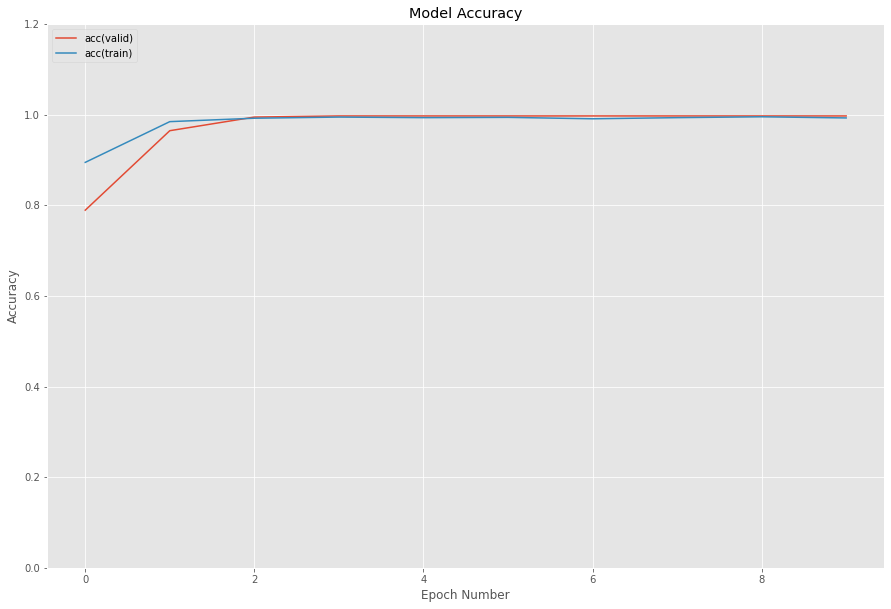

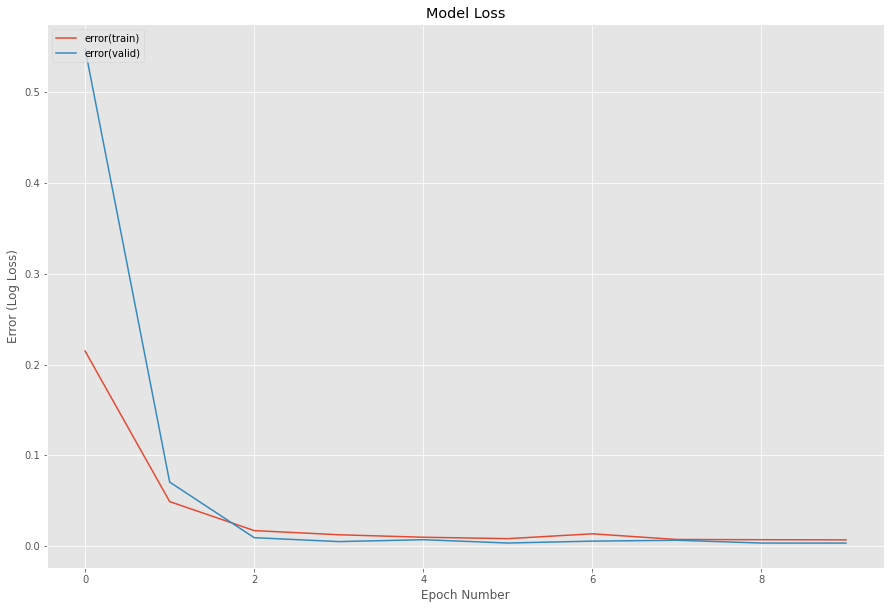

In [0]:
run_this = False #Prevent accidental execution

if run_this:
  model = InceptionNet()

  # Early stopping by only saving the weight with the best validation accuracy
  checkpoint = ModelCheckpoint(MODEL_WEIGHT_FILE, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
  callbacks_list = [checkpoint]
  
  #Training
  history = model.fit(x=X_train,y=y_train,
                      validation_data=(X_valid,y_valid),
                      batch_size=BATCH_SIZE,
                      epochs = EPOCH,
                      callbacks = callbacks_list)

  #Generate training graphs
  generateTrainingPlots(history.history) 

# 5. Evaluation

The model is evaluated against the test samples. Unfortunately, there are only 8 test samples available.  A high variation of scores will be expected.

In [0]:
X_test, y_test, _ = buildImageDataset(TEST_DIR, imageResize=IMAGE_RESIZE, seed=SEED)
X_test /= 255.0

In [0]:
# Sanity Check
print ("Shape of the Evaluation Input: {}".format(X_test.shape))
print ("Shape of the Evaluation Target: {}".format(y_test.shape))


Shape of the Evaluation Input: (8, 299, 299, 3)
Shape of the Evaluation Target: (8,)


In [0]:
y_pred = model.predict(X_test)

In [0]:
# Translate the sigmoid output into 0s and 1s
predict_result = []
for a,b in y_pred:
  if a > b:
    predict_result.append(0)
  else:
    predict_result.append(1)

In [0]:
def plot_confusion_matrix(cm, classes=None, title='Confusion matrix'):
    """Plots a confusion matrix."""
    if classes is not None:
        sns.heatmap(cm, xticklabels=classes, yticklabels=classes, vmin=0., vmax=1., annot=True)
    else:
        sns.heatmap(cm, vmin=0., vmax=1., annot=True)
    plt.title(title)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
def plot_ROC(y, y_pred):
    fpr, tpr, threshold = roc_curve(y, y_pred)
    roc_auc = auc(fpr, tpr)
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

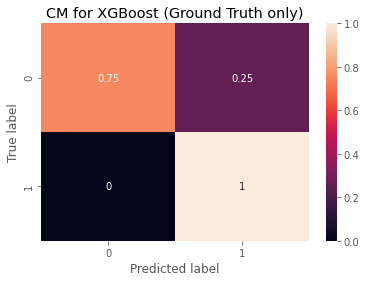

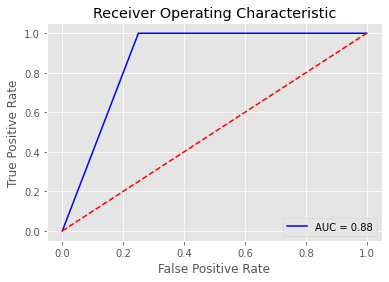

Precision 0.9 Recall 0.875 F1 0.873015873015873


In [0]:
# Display CM from one of tests
cm = confusion_matrix(y_test, predict_result)
cm = cm / cm.sum(axis=1)[:, np.newaxis]
plot_confusion_matrix(cm, title="CM for XGBoost (Ground Truth only)")    
plt.show()

# Plot ROC
plot_ROC(y_test, predict_result)

# Summarize Scores
scores = precision_recall_fscore_support(y_test, predict_result, average="macro")
print("Precision {} Recall {} F1 {}".format(scores[0], scores[1], scores[2]))

# 5. Analysis

The model performs quite well with 1 missed label on the given 8 images.
Based on the 99% validation performance over hundreds of images in the validation set, I believe this model is suitable for production deployment. 

# 6. Conclusion

In this task, I developed a machine learning model capable of classifying pictures of Wat Pho and Wat Phra Kaew for images in the wild. The training data is mined using Bing and Google Image Search API. Due to limited resources, I leveraged transfer learning using Inception-v3 Convolutional Neural Network initialized with pre-trained weights from ImageNet competition. The model has over 99% accuracy in the validation set, and it can correctly classify 7 out of 8 test images given by the committee. 